# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [39]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame already exists
sys.path:  ['/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python312.zip', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12', '/home/ubuntu/.local/share/uv/python/cpython-3.12.11-linux-aarch64-gnu/lib/python3.12/lib-dynload', '', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame/setup/.venv/lib/python3.12/site-packages', '/home/ubuntu/projects/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/08_bedrock_manus/use_cases/04_basic_agent_frame']


## 1. Create Bedrock client
Amazon Bedrock을 API로 활용하기 위한 Client를 설정합니다. 

In [42]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from src.utils import bedrock
from src.utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [43]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-7-Sonnet-CRI': 'us.anthropic.claude-3-7-sonnet-20250219-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V4-Opus-CRI': 'us.anthropic.claude-opus-4-20250514-v1:0',
 'Claude-V4-Sonnet-CRI': 'us.anthropic.claude-sonnet-4-20250514-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': '

## 2. Titan Embedding v2 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [44]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [60]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-7-Sonnet-CRI"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 8192,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0xe337a33f1c10>], client=<botocore.client.BedrockRuntime object at 0xe337a33ce780>, model_id='us.anthropic.claude-3-7-sonnet-20250219-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=8192)

### Embedding 모델 선택

In [61]:
from langchain_aws import BedrockEmbeddings

In [62]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 

### Extract Text, Table and Image from documents

### 3.1 Upstage Document Parse
- ### Prerequisites
    - #### 해당 에셋은 complex document parsing을 위해 [Upstage Document Parse](https://aws.amazon.com/marketplace/pp/prodview-lv5bnpdco7xoq?sr=0-4&ref_=beagle&applicationId=AWSMPContessa)을 이용합니다. 
    - Upstage Document Parse는 AWS Marketplace에 등록되어 있으며, Amazon SageMaker Endpoint 생성을 통해 사용하실 수 있습니다.
        - Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.
- ### **[API Description](https://developers.upstage.ai/docs/apis/document-parse)**


In [63]:
import shutil
from glob import glob
from requests_toolbelt import MultipartEncoder

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

from src.utils.common_utils import to_pickle, load_pickle
from langchain.schema import Document

**엔드포인트 이름을 입력합니다.**
- Endpoint 생성 방식은 **["05_1_create_endpoint_upstage_document_parse.ipynb"](./05_1_create_endpoint_upstage_document_parse.ipynb)** 참고하시기 바랍니다.

In [64]:
endpoint_document_parser = "<your endpont>"
endpoint_document_parser = "Upstage-Document-Parse-Test-2025-08-20-07-49-44-760"

**추출할 문서의 위치를 입력합니다.**

In [140]:
file_path = "../data/sample.pdf"

**추출된 이미지가 저장될 위치를 입력합니다.**

In [141]:
image_path = "./fig"

**문서 파싱을 시작합니다 (약 1분 소요)**

In [142]:
%%time

if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

runtime_sm_client = boto3.client('runtime.sagemaker')

# Prepare multipart form data
encoder = MultipartEncoder(
    fields={
        'document': (os.path.basename(file_path), open(file_path, 'rb'), 'application/pdf'),
        'model': 'document-parse',
        'ocr': 'auto',
        'coordinates': 'true',
        'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
        'base64_encoding': '["table", "figure"]',
        'chart_recognition': 'false',
    }
)

# Get the raw bytes of the multipart form data
body = encoder.to_string()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_document_parser,
    ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
    Body=body
)

result = response["Body"].read()
parse_output = json.loads(result)

CPU times: user 48.1 ms, sys: 1.01 ms, total: 49.1 ms
Wall time: 1.4 s


In [143]:
parse_output

{'api': '2.0',
 'content': {'html': '',
  'markdown': '핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단

In [144]:
to_pickle(parse_output, "sample.pkl")

To_PICKLE: sample.pkl


In [145]:
parse_output = load_pickle("sample.pkl")

Load from sample.pkl


In [146]:
parse_output.keys()

dict_keys(['api', 'content', 'elements', 'merged_elements', 'model', 'ocr', 'usage'])

In [147]:
parse_output["content"]

{'html': '',
 'markdown': '핵 심 설 명 서\n\n이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.\n\n# 핵심설명서\n\n# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]\n\n# 1\n\n# 상품 개요\n\n- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 100 만원 이상 100 만원 단위 (발행 후 추가 납입 불가)\n- ○ 발 행 일 : 2011 년 07 월 08 일\n- ○ 만 기 일 : 2012 년 07 월 09 일(만기 1 년)\n- ○ 상품위험등급: 4 등급\n\n\n# 2\n\n# 기준가격 결정일 및 평가방법\n\n- ○ 최초 기준가격: 2011 년 07 월 07 일의 종가(해당 거래소 기준)\n- ○ 만기 평가가격: 2012 년 07 월 03 일의 종가(해당 거래소 기준)\n\n\n# 3 손익 구조\n\n| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n\n\n※ 만기수익률=(만기평가가격-최초기준가격)/최초기준가격\n(단, {(만기평가가격-최초기준가격)/최초기준가격×70

In [148]:
parse_output["elements"][1]#.keys()

{'category': 'paragraph',
 'content': {'html': '',
  'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
  'text': ''},
 'coordinates': [{'x': 0.2009, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0173},
  {'x': 0.9314, 'y': 0.0702},
  {'x': 0.2009, 'y': 0.0702}],
 'id': 1,
 'page': 1}

**문서 파싱 후처리를 합니다.**
- docs: 문서는 페이지별 정리
- texts: markdown 형식의 전체 texts

In [149]:
def postprocessing(**kwargs):
    
    category = kwargs["category"]
    markdown = kwargs["markdown"]
    base64_encoding = kwargs["base64_encoding"]
    coordinates = kwargs["coordinates"]
    page = kwargs["page"]
    docs = kwargs["docs"]
    
    if page in docs: 
        docs[page].append({"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates})
    else:
        docs[page] = [{"category": category, "markdown": markdown, "base64_encoding": base64_encoding, "coordinates": coordinates}]
        
    return docs

def extract_image_table(**kwargs):
    
    image_path = kwargs["image_path"]
    file_path = kwargs["file_path"]
    
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)

    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")
        
    return image_tmp_path

pdf page 0, size: (1654, 2339)
pdf page 1, size: (1654, 2339)
pdf page 2, size: (1654, 2339)


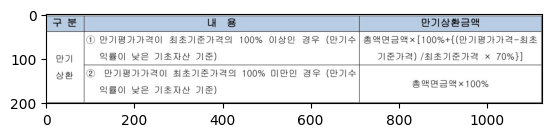

page_number: 1
==
image: ./fig/element-11.jpg, shape: (1501, 270), image_token_for_claude3: 540.36


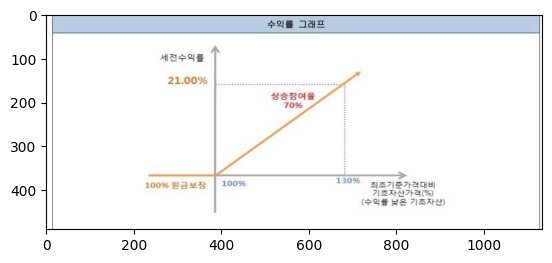

page_number: 3
==
image: ./fig/element-42.jpg, shape: (1511, 653), image_token_for_claude3: 1315.5773333333334


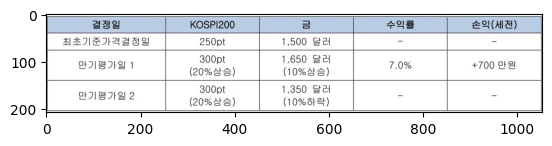

page_number: 3
==
image: ./fig/element-45.jpg, shape: (1402, 278), image_token_for_claude3: 519.6746666666667


In [150]:
docs = {}
texts = [
    Document(
        page_content=parse_output["content"]["markdown"]
    )
]

## extract_image_table
image_tmp_path = extract_image_table(
    image_path=image_path,
    file_path=file_path
)

for idx, value in enumerate(parse_output["elements"]):
      
    category = value["category"]
    markdown = value["content"]["markdown"]
    page = value["page"]
    
    if category in ["figure", "table"]:
        
        base64_encoding = value["base64_encoding"]    
        coordinates = value["coordinates"]    
        img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
        plt.imshow(img)
        plt.show()
        
        # PIL로 이미지 로드
        page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
        w, h = page_img.size  # PIL은 (width, height) 순서
        
        # 좌표 계산
        left = math.ceil(coordinates[0]["x"] * w)
        top = math.ceil(coordinates[0]["y"] * h)
        right = math.ceil(coordinates[1]["x"] * w)
        bottom = math.ceil(coordinates[3]["y"] * h)
        
        # PIL로 이미지 크롭
        crop_img = page_img.crop((left, top, right, bottom))
                
        crob_image_path = f'{image_path}/element-{idx}.jpg'
        crop_img.save(crob_image_path)

        print (f'page_number: {page}')
        print ("==")

        w_crop, h_crop = crop_img.size
        image_token = w_crop*h_crop/750
        print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
        
    else:
        base64_encoding= ""
        coordinates=""

    docs = postprocessing(
        docs=docs,
        page=page,
        category=category,
        markdown=markdown,
        base64_encoding=base64_encoding,
        coordinates=coordinates
    )

In [151]:
docs

{1: [{'category': 'paragraph',
   'markdown': '핵 심 설 명 서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'paragraph',
   'markdown': '이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여\n금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을\n충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 핵심설명서',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 1',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'heading1',
   'markdown': '# 상품 개요',
   'base64_encoding': '',
   'coordinates': ''},
  {'category': 'list',
   'markdown': '- ○ 모집가액: 100 억원 (모집된 금액이 10 억 미만일 경우 발행이 취소될 수 있음)\n- ○ 기초자산: KOSPI200 지수(블룸버그 Ticker: KOSPI2 index),\n- 금가격지수 (블룸버그 Ticker: GOLDLNPM index)\n- ○ 청약기간 : 2011 년 07 월 04 일 ~2011 년 07 월 07 일 16 시\n- ○ 청약단위 : 1

### Summarization of table and image
- **Image 및 Table 내용을 text 기반으로 요약합니다.**
- **Image 및 Table이 포함된 페이지의 내용을 추가 정보로 사용하여 문맥을 고려한 요약을 합니다.**
- **이 과정은 image 및 table 정보를 embedding 기반 모델로 검색 가능하게 합니다.**
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [152]:
import copy
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

**요약 대상과 그에 대한 컨텍스트 정보를 구분합니다**

In [153]:
docs_for_summary = []
for page, elements in docs.items():
    
    elements = [element for element in elements if element["category"] != "footer"]
    print (f'page: {page}, # elements: {len(elements)}')
    
    for idx, element in enumerate(elements):
        
        category, markdown = element["category"], element["markdown"]
        print (f'element idx: {idx}, category: {element["category"]}')
        
        elements_copy = copy.deepcopy(elements)
        if category in ("figure", "table"):  
            
            summary_target = elements_copy.pop(idx)
            contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
            docs_for_summary.append(
                {
                    "target_category": summary_target["category"],
                    "target_base64": summary_target["base64_encoding"],
                    "target_markdown": summary_target["markdown"],
                    "contexts_markdown": contexts_markdown
                }
            )

page: 1, # elements: 17
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: heading1
element idx: 5, category: heading1
element idx: 6, category: list
element idx: 7, category: heading1
element idx: 8, category: heading1
element idx: 9, category: list
element idx: 10, category: heading1
element idx: 11, category: table
element idx: 12, category: paragraph
element idx: 13, category: heading1
element idx: 14, category: paragraph
element idx: 15, category: list
element idx: 16, category: list
page: 2, # elements: 22
element idx: 0, category: paragraph
element idx: 1, category: paragraph
element idx: 2, category: heading1
element idx: 3, category: heading1
element idx: 4, category: paragraph
element idx: 5, category: paragraph
element idx: 6, category: heading1
element idx: 7, category: paragraph
element idx: 8, category: paragraph
element idx: 9, category: list
element idx: 

In [154]:
docs_for_summary

[{'target_category': 'table',
  'target_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP0jP7b/APwUfCCRv2XfgiQWIGPi9rHbH/UC56jmk/4bk/4KPAYX9lz4Jf8Ah3dY/wDlFU8n/Hon/XV/5LUQODmvqVlWDa2f3nz7zLFJ9PuE/wCG5P8Ago8P+bXvgif+6u6x/wDKKhv24/8Ago+P+bXPgl/4d7WP/lFXzP

**정보를 요약합니다**

In [155]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from src.utils.common_utils import retry
from botocore.exceptions import ClientError

In [156]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 <contexts>
                 {contexts}
                 </contexts>
                 
                 주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:
                 
                 1. <title> 태그 안의 제목을 정확히 제시해주세요.
                 2. <summary> 태그 안의 내용을 요약해주세요.
                 3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                 4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [157]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()

In [158]:
@retry(total_try_cnt=5, sleep_in_sec=60, retryable_exceptions=(ClientError,))
def summary_img(summarize_chain, image_base64, contexts):

    img = Image.open(BytesIO(base64.b64decode(image_base64)))
    plt.imshow(img)
    plt.show()

    stream = summarize_chain.stream(
        {
            "image_base64": image_base64,
            "contexts": contexts
        }
    )
    response = ""
    for chunk in stream: response += chunk

    return response

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


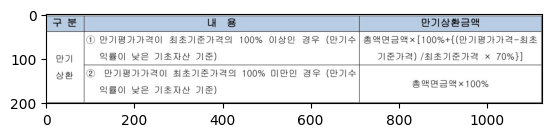

The image shows a table in Korean that appears to describe calculation methods for maturity amounts. The table has three columns with headers "구분" (Category), "내용" (Content), and "만기상환금액" (Maturity Amount).

Based on the given contexts, I'll extract the requested information:

## <title>
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## <summary>
이 문서는 미래에셋증권이 발행하는 제253회 파생결합증권(DLS)에 대한 핵심설명서입니다. 이 상품은 원금보장형으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 파생결합증권입니다. 총 모집가액은 100억원이며, 2011년 7월에 발행되어 2012년 7월에 만기가 되는 1년 만기 상품입니다. 만기 시 상환금액은 기초자산의 성과에 따라 결정되며, 원금은 100% 보장됩니다.

## <entities>
- KOSPI200 지수: 한국 주식시장의 대표적인 지수로, 이 상품의 기초자산 중 하나입니다.
- 금가격지수: 금 가격을 나타내는 지수로, 이 상품의 또 다른 기초자산입니다.
- 최초기준가격: 2011년 07월 07일의 종가로 결정됩니다.
- 만기평가가격: 2012년 07월 03일의 종가로 결정됩니다.
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격으로 계산됩니다.
- 상품위험등급: 4등급으로 분류됩니다.

## <hypothetical_questions>
- 만기평가가격이 최초기준가격보다 높을 경우 어떤 수익을 얻을 수 있나요?
- 원금보장은 어떤 조건에서 이루어지나요?
- 두 기초자산의 성과가 다를 경우 수익률은 어떻게 계산되나요?
- 조기상환 조건이 있나요?
- 투자 최소 금액은 얼마인가요?

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'The image shows a table in Korean that appears to describe calculation methods for maturity amounts. The table has three columns with headers "구분" (Category), "내용" (Content), and "만기상환금액" (Maturity Amount).

Based on the given contexts, I'll extract the requested information:

## <title>
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## <summary>
이 문서는 미래에셋증권이 발행하는 제253회 파생결합증권(DLS)에 대한 핵심설명서입니다. 이 상품은 원금보장형으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 파생결합증권입니다. 총 모집가액은 100억원이며, 2011년 7월에 발행되어 2012년 7월에 만기가 되는 1년 만기 상품입니다. 만기 시 상환금액은 기초자산의 성과에 따라 결정되며, 원금은 100% 보장됩니다.

## <entities>
- KOSPI200 지수: 한국 주식시장의 대표적인 지수로, 이 상품의 기초자산 중 하나입니다.
- 금가격지수: 금 가격을 나타내는 지수로, 이 상품의 또 다른 기초자산입니다.
- 최초기준가격: 2011년 07월 07일의 종가로 결정됩니다.
- 만기평가가격: 2012년 07월 03일의 종가로 결정됩니다.
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격으로 계산됩니다.
- 상품위험등급: 4등급으로 분류됩니다.

## <hypothetical_questions>
- 만기평가가격이 최초기준가격보다 높을 경우 어떤 수익을 얻을 수 있나요?
- 원금보장은 어떤 조건에서 이루어지나요?
- 두 기초자산의 성과가 다를 경우 수익률은 어떻게 계산되나요?
-


==
0


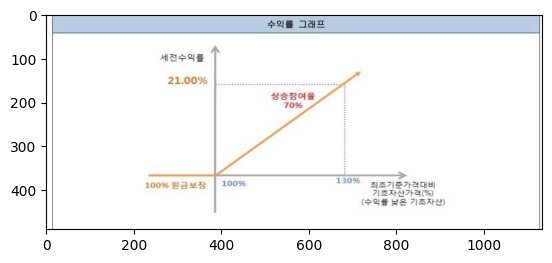

Based on the image and context provided, I'll extract and analyze the information requested:

<title>수익률 그래프</title>

<summary>
이 이미지는 금융 상품의 수익률 구조를 보여주는 그래프입니다. 그래프는 기초자산가격대비 기초자산선가격(%)을 x축으로, 세전수익률을 y축으로 표시하고 있습니다. 기초자산이 130%까지 상승할 경우 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%로 표시되어 있습니다. 또한 원금보장은 100%로 표시되어 있습니다. 이 그래프는 금융소비자가 투자 상품의 손익 구조를 이해하는 데 도움을 주기 위한 핵심설명서의 일부입니다.
</summary>

<entities>
1. 상승참여율 70% - 기초자산의 상승에 따른 수익 참여 비율
2. 세전수익률 21.00% - 세금 공제 전 최대 가능한 수익률
3. 100% 원금보장 - 투자 원금이 100% 보장됨을 나타냄
4. 기초자산 - 주어진 컨텍스트에서는 KOSPI200과 금가격이 기초자산으로 언급됨
5. 기초자산가격대비 기초자산선가격(%) - x축에 표시된 값으로 기초자산의 가격 변화 비율
6. 130% - 기초자산가격이 30% 상승했을 때의 지점
</entities>

<hypothetical_questions>
1. 기초자산가격이 130%일 때 얻을 수 있는 수익률은 얼마인가요?
2. 상승참여율 70%는 어떤 의미를 가지고 있나요?
3. 원금보장은 어떤 조건에서 이루어지나요?
4. KOSPI200과 금가격이 각각 20% 상승하면 최종 수익률은 어떻게 되나요?
5. 만약 기초자산 가격이 하락할 경우 투자자의 손실은 어떻게 되나요?
6. 그래프에서 보여주는 최대 수익률은 어떤 조건에서 달성 가능한가요?
</hypothetical_questions>

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'Based on the image and context provided, I'll extract and analyze the information requested:

<title>수익률 그래프</title>

<summary>
이 이미지는 금융 상품의 수익률 구조를 보여주는 그래프입니다. 그래프는 기초자산가격대비 기초자산선가격(%)을 x축으로, 세전수익률을 y축으로 표시하고 있습니다. 기초자산이 130%까지 상승할 경우 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%로 표시되어 있습니다. 또한 원금보장은 100%로 표시되어 있습니다. 이 그래프는 금융소비자가 투자 상품의 손익 구조를 이해하는 데 도움을 주기 위한 핵심설명서의 일부입니다.
</summary>

<entities>
1. 상승참여율 70% - 기초자산의 상승에 따른 수익 참여 비율
2. 세전수익률 21.00% - 세금 공제 전 최대 가능한 수익률
3. 100% 원금보장 - 투자 원금이 100% 보장됨을 나타냄
4. 기초자산 - 주어진 컨텍스트에서는 KOSPI200과 금가격이 기초자산으로 언급됨
5. 기초자산가격대비 기초자산선가격(%) - x축에 표시된 값으로 기초자산의 가격 변화 비율
6. 130% - 기초자산가격이 30% 상승했을 때의 지점
</entities>

<hypothetical_questions>
1. 기초자산가격이 130%일 때 얻을 수 있는 수익률은 얼마인가요?
2. 상승참여율 70%는 어떤 의미를 가지고 있나요?
3. 원금보장은 어떤 조건에서 이루어지나요?
4. KOSPI200과 금가격이 각각 20% 상승하면 최종 수익률은 어떻게 되나요?
5. 만약 기초자산 가격이 하락할 경우 투자자의 손실은 어떻게 되나요?
6. 그래프에서 보여주는 최대 수익률은 어떤 조건에서 달성 가능한가요?
</hypothetical_questions>'
INFO:retry-be


==
1


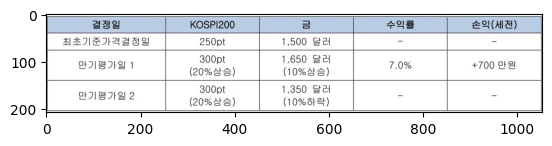

The image shows a financial investment table that appears to be part of an investment product explanation document. The table has 5 columns labeled "결정일" (Decision Date), "KOSPI200", "금" (Gold), "수익률" (Return Rate), and "손익(세전)" (Profit/Loss before tax).

The table contains three scenarios:
1. Initial benchmark price determination day: KOSPI200 at 250pt, Gold at $1,500, with no return rate or profit/loss indicated
2. Maturity price determination day 1: KOSPI200 at 300pt (20% increase), Gold at $1,650 (10% increase), with 7.0% return rate and +7,000,000 KRW profit
3. Maturity price determination day 2: KOSPI200 at 300pt (20% increase), Gold at $1,350 (10% decrease), with no indicated return rate or profit/loss

Based on the provided context:

1. Title: 핵심설명서 (Key Explanation Document)

2. Summary: The document is created to protect financial consumers' rights and enhance understanding of financial products by explaining the core content of financial products in an easily understandable 

INFO:retry-bedrock-invocation:in retry(), summary_img() returned 'The image shows a financial investment table that appears to be part of an investment product explanation document. The table has 5 columns labeled "결정일" (Decision Date), "KOSPI200", "금" (Gold), "수익률" (Return Rate), and "손익(세전)" (Profit/Loss before tax).

The table contains three scenarios:
1. Initial benchmark price determination day: KOSPI200 at 250pt, Gold at $1,500, with no return rate or profit/loss indicated
2. Maturity price determination day 1: KOSPI200 at 300pt (20% increase), Gold at $1,650 (10% increase), with 7.0% return rate and +7,000,000 KRW profit
3. Maturity price determination day 2: KOSPI200 at 300pt (20% increase), Gold at $1,350 (10% decrease), with no indicated return rate or profit/loss

Based on the provided context:

1. Title: 핵심설명서 (Key Explanation Document)

2. Summary: The document is created to protect financial consumers' rights and enhance understanding of financial products by explaining t


==
2


In [159]:
summaries = []
for idx, doc in enumerate(docs_for_summary):
    summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
    summaries.append(summary)
    print ("\n==")
    print (idx)

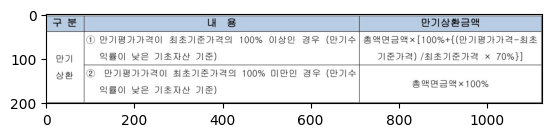

Summary: The image shows a table in Korean that appears to describe calculation methods for maturity amounts. The table has three columns with headers "구분" (Category), "내용" (Content), and "만기상환금액" (Maturity Amount).

Based on the given contexts, I'll extract the requested information:

## <title>
미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)

## <summary>
이 문서는 미래에셋증권이 발행하는 제253회 파생결합증권(DLS)에 대한 핵심설명서입니다. 이 상품은 원금보장형으로, KOSPI200 지수와 금가격지수를 기초자산으로 하는 파생결합증권입니다. 총 모집가액은 100억원이며, 2011년 7월에 발행되어 2012년 7월에 만기가 되는 1년 만기 상품입니다. 만기 시 상환금액은 기초자산의 성과에 따라 결정되며, 원금은 100% 보장됩니다.

## <entities>
- KOSPI200 지수: 한국 주식시장의 대표적인 지수로, 이 상품의 기초자산 중 하나입니다.
- 금가격지수: 금 가격을 나타내는 지수로, 이 상품의 또 다른 기초자산입니다.
- 최초기준가격: 2011년 07월 07일의 종가로 결정됩니다.
- 만기평가가격: 2012년 07월 03일의 종가로 결정됩니다.
- 만기수익률: (만기평가가격-최초기준가격)/최초기준가격으로 계산됩니다.
- 상품위험등급: 4등급으로 분류됩니다.

## <hypothetical_questions>
- 만기평가가격이 최초기준가격보다 높을 경우 어떤 수익을 얻을 수 있나요?
- 원금보장은 어떤 조건에서 이루어지나요?
- 두 기초자산의 성과가 다를 경우 수익률은 어떻게 계산되나요?
- 조기상환 조건이 있나요?
- 투자 최소 금액은 얼마인가요?


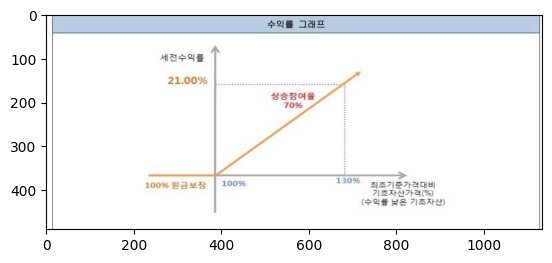

Summary: Based on the image and context provided, I'll extract and analyze the information requested:

<title>수익률 그래프</title>

<summary>
이 이미지는 금융 상품의 수익률 구조를 보여주는 그래프입니다. 그래프는 기초자산가격대비 기초자산선가격(%)을 x축으로, 세전수익률을 y축으로 표시하고 있습니다. 기초자산이 130%까지 상승할 경우 21.00%의 수익률을 얻을 수 있으며, 상승참여율은 70%로 표시되어 있습니다. 또한 원금보장은 100%로 표시되어 있습니다. 이 그래프는 금융소비자가 투자 상품의 손익 구조를 이해하는 데 도움을 주기 위한 핵심설명서의 일부입니다.
</summary>

<entities>
1. 상승참여율 70% - 기초자산의 상승에 따른 수익 참여 비율
2. 세전수익률 21.00% - 세금 공제 전 최대 가능한 수익률
3. 100% 원금보장 - 투자 원금이 100% 보장됨을 나타냄
4. 기초자산 - 주어진 컨텍스트에서는 KOSPI200과 금가격이 기초자산으로 언급됨
5. 기초자산가격대비 기초자산선가격(%) - x축에 표시된 값으로 기초자산의 가격 변화 비율
6. 130% - 기초자산가격이 30% 상승했을 때의 지점
</entities>

<hypothetical_questions>
1. 기초자산가격이 130%일 때 얻을 수 있는 수익률은 얼마인가요?
2. 상승참여율 70%는 어떤 의미를 가지고 있나요?
3. 원금보장은 어떤 조건에서 이루어지나요?
4. KOSPI200과 금가격이 각각 20% 상승하면 최종 수익률은 어떻게 되나요?
5. 만약 기초자산 가격이 하락할 경우 투자자의 손실은 어떻게 되나요?
6. 그래프에서 보여주는 최대 수익률은 어떤 조건에서 달성 가능한가요?
</hypothetical_questions>


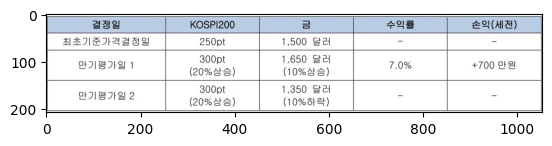

Summary: The image shows a financial investment table that appears to be part of an investment product explanation document. The table has 5 columns labeled "결정일" (Decision Date), "KOSPI200", "금" (Gold), "수익률" (Return Rate), and "손익(세전)" (Profit/Loss before tax).

The table contains three scenarios:
1. Initial benchmark price determination day: KOSPI200 at 250pt, Gold at $1,500, with no return rate or profit/loss indicated
2. Maturity price determination day 1: KOSPI200 at 300pt (20% increase), Gold at $1,650 (10% increase), with 7.0% return rate and +7,000,000 KRW profit
3. Maturity price determination day 2: KOSPI200 at 300pt (20% increase), Gold at $1,350 (10% decrease), with no indicated return rate or profit/loss

Based on the provided context:

1. Title: 핵심설명서 (Key Explanation Document)

2. Summary: The document is created to protect financial consumers' rights and enhance understanding of financial products by explaining the core content of financial products in an easily unders

In [160]:
verbose = True
if verbose:
    for doc, summary in zip(docs_for_summary, summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(doc["target_base64"])))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [161]:
images_preprocessed = []

for doc, summary in zip(docs_for_summary, summaries):
    
    metadata = {}
    metadata["markdown"] = doc["target_markdown"]
    metadata["category"] = "Image"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [162]:
images_preprocessed[0]

Document(metadata={'markdown': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAMoEZgMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYm

### For tables (summary for markdown)
- 테이블의 경우 이미지 뿐만 아니라 마크다운 형태로도 가지고 있음

In [163]:
tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]

In [164]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [165]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [94]:
table_info = [t["target_markdown"] for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 스마트 하이빔(SHB) 기능에 관한 주의사항을 설명하고 있습니다. 표의 왼쪽에는 "드라이브 모드(p.329) 참조"라는 안내가 있고, 오른쪽에는 스마트 하이빔이 정상적으로 작동하지 않을 수 있는 여러 상황이 나열되어 있습니다. 이러한 상황으로는 앞유리의 오염 상태, 다른 차량의 램프 손상, 시야 가림, 굴곡 도로에서의 부분 인식, 유사 광원이나 반사체 존재, 공사 구간의 발광체 등이 있습니다. 표 상단에는 스마트 하이빔에 대한 참조 페이지(p.160)도 안내하고 있습니다.이 표는 황색 경고등에 관한 안내를 담고 있습니다. 황색 경고등이 켜질 경우, 당사 정비사업장에서 점검 및 정비를 받아야 한다고 설명하고 있습니다.이 표는 경고에 관한 정보를 제공하고 있습니다. 황색 비사업장에서 경고등이 켜지거나 깜빡이면 당사 정비점에서 점검 및 정비를 받아야 한다는 내용을 안내하고 있습니다.이 표는 황색 경고등에 관한 내용을 담고 있습니다. 왼쪽 열에는 "y 황색 경고등이 비사업장에서"라는 조건이 제시되어 있고, 오른쪽 열에는 이런 상황이 발생했을 때 "켜지거나 깜빡이면 당사 정점검 및 정비를 받으십시오"라는 안내가 있습니다. 즉, 황색 경고등이 켜지거나 깜빡이는 경우 공식 서비스 센터에서 점검과 정비를 받아야 한다는 내용입니다.이 표는 자동차 상향등 사용에 관한 경고 사항을 담고 있습니다. 상향등을 켜고 주행하면 마주 오는 차량 운전자의 시야를 방해하여 안전 운행에 지장을 줄 수 있다고 경고하고 있습니다. 따라서 상향등은 야간 주행 시 주변이 어둡거나 전방 상황을 예측하기 힘들 때만 사용해야 한다고 안내하고 있습니다.이 표는 경고 상황에 대한 안내입니다. 녹색 표시등이 켜지지 않거나 적색 경고등이 깜박일 경우, 해당 차량을 당사 정비사업장에서 점검 및 정비받아야 함을 알려주고 있습니다.이 테이블은 경고 안내문입니다. 주행 중 경고등이 켜지거나 시동 후 경고등이 꺼지지 않을 경우, 즉시 해당 정비사업장에서 점검 및 정비를 받아야 한다는 내용을 담고 있습니다.이 테이

`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [95]:
tables_preprocessed = []

for doc, summary in zip(tables, table_summaries):
    
    metadata = {}
    metadata["origin_table"] = doc["target_markdown"]
    metadata["text_as_html"] = doc["target_markdown"]
    metadata["category"] = "Table"
    metadata["image_base64"] = doc["target_base64"]
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

In [96]:
tables_preprocessed[0]

Document(metadata={'origin_table': '|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n', 'text_as_html': '|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n', 'category': 'Table', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKC

0
table: |  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |
| --- | --- |
|  | 주 의 |
| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |

----------------------------
summary: 이 표는 스마트 하이빔(SHB) 기능에 관한 주의사항을 설명하고 있습니다. 표의 왼쪽에는 "드라이브 모드(p.329) 참조"라는 안내가 있고, 오른쪽에는 스마트 하이빔이 정상적으로 작동하지 않을 수 있는 여러 상황이 나열되어 있습니다. 이러한 상황으로는 앞유리의 오염 상태, 다른 차량의 램프 손상, 시야 가림, 굴곡 도로에서의 부분 인식, 유사 광원이나 반사체 존재, 공사 구간의 발광체 등이 있습니다. 표 상단에는 스마트 하이빔에 대한 참조 페이지(p.160)도 안내하고 있습니다.
----------------------------
----------------------------
image


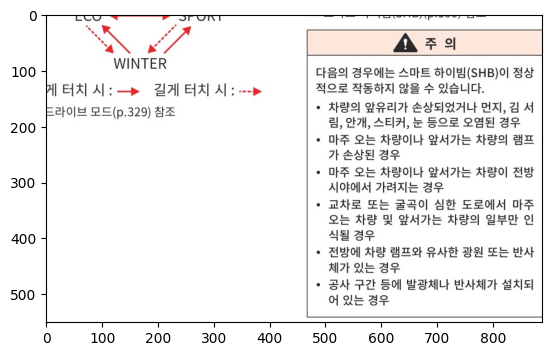

1
table: |  | 경 고 |
| --- | --- |
| y 황색 경고등이 에서 점검 및 | 켜질 경우 당사 정비사업장 정비를 받으십시오. |

----------------------------
summary: 이 표는 황색 경고등에 관한 안내를 담고 있습니다. 황색 경고등이 켜질 경우, 당사 정비사업장에서 점검 및 정비를 받아야 한다고 설명하고 있습니다.
----------------------------
----------------------------
image


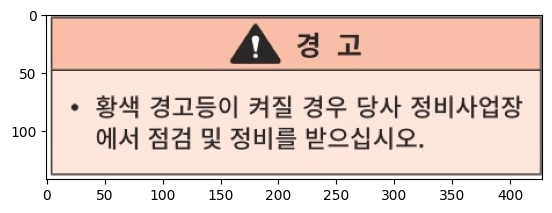

2
table: |  | 경 고 |
| --- | --- |
| y 황색 비사업장에서 | 경고등이 켜지거나 깜빡이면 당사 정 점검 및 정비를 받으십시오. |

----------------------------
summary: 이 표는 경고에 관한 정보를 제공하고 있습니다. 황색 비사업장에서 경고등이 켜지거나 깜빡이면 당사 정비점에서 점검 및 정비를 받아야 한다는 내용을 안내하고 있습니다.
----------------------------
----------------------------
image


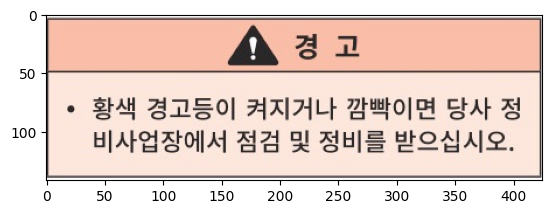

3
table: |  | 경 고 |
| --- | --- |
| y 황색 경고등이 비사업장에서 | 켜지거나 깜빡이면 당사 정 점검 및 정비를 받으십시오. |

----------------------------
summary: 이 표는 황색 경고등에 관한 내용을 담고 있습니다. 왼쪽 열에는 "y 황색 경고등이 비사업장에서"라는 조건이 제시되어 있고, 오른쪽 열에는 이런 상황이 발생했을 때 "켜지거나 깜빡이면 당사 정점검 및 정비를 받으십시오"라는 안내가 있습니다. 즉, 황색 경고등이 켜지거나 깜빡이는 경우 공식 서비스 센터에서 점검과 정비를 받아야 한다는 내용입니다.
----------------------------
----------------------------
image


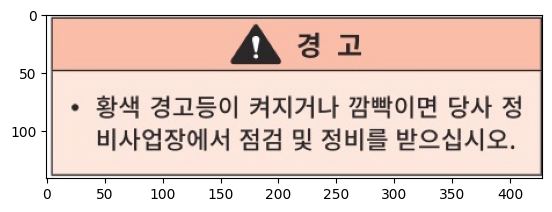

4
table: | 경 | 고 |
| --- | --- |
| y 상향등을 켜고 | 주행하면 마주 오는 차량의 |
| 운전자 시야를 방해하여 | 안전 운행에 지장을 |
| 줄 수 있으므로 | 상향등은 야간 주행 시 주변 |
| 이 어둡거나 전방 | 상황을 예측하기 힘들 |
| 만 사용하십시오. | 때 |

----------------------------
summary: 이 표는 자동차 상향등 사용에 관한 경고 사항을 담고 있습니다. 상향등을 켜고 주행하면 마주 오는 차량 운전자의 시야를 방해하여 안전 운행에 지장을 줄 수 있다고 경고하고 있습니다. 따라서 상향등은 야간 주행 시 주변이 어둡거나 전방 상황을 예측하기 힘들 때만 사용해야 한다고 안내하고 있습니다.
----------------------------
----------------------------
image


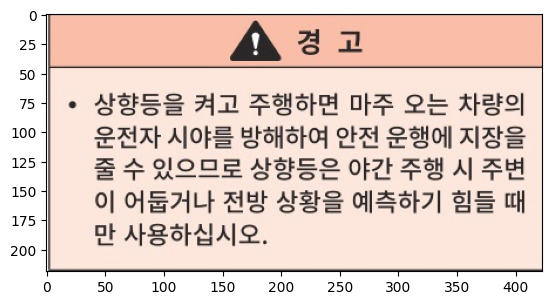

5
table: |  | 경 고 |
| --- | --- |
| y 녹색 표시등이 | 켜지지 않거나, 적색 경고등 |
| 이 깜박이면 정비를 | 당사 정비사업장에서 점검 및 받으십시오. |

----------------------------
summary: 이 표는 경고 상황에 대한 안내입니다. 녹색 표시등이 켜지지 않거나 적색 경고등이 깜박일 경우, 해당 차량을 당사 정비사업장에서 점검 및 정비받아야 함을 알려주고 있습니다.
----------------------------
----------------------------
image


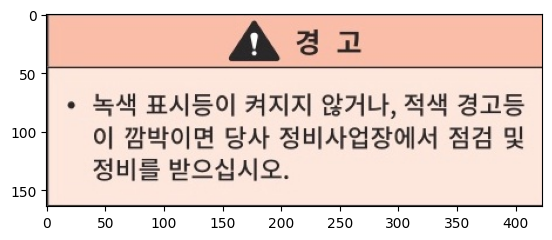

6
table: | 경 고 |
| --- |
| y 주행 중 경고등이 켜지거나, 시동 후 경고등 이 꺼지지 않을 경우 즉시 당사 정비사업장 에서 점검 및 정비를 받으십시오. |

----------------------------
summary: 이 테이블은 경고 안내문입니다. 주행 중 경고등이 켜지거나 시동 후 경고등이 꺼지지 않을 경우, 즉시 해당 정비사업장에서 점검 및 정비를 받아야 한다는 내용을 담고 있습니다.
----------------------------
----------------------------
image


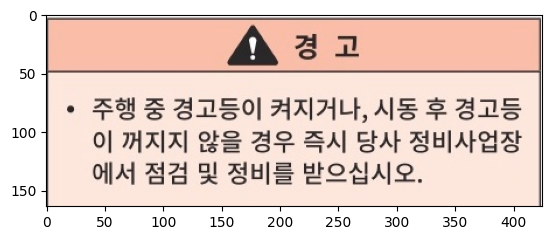

7
table: | 경 고 |
| --- |
| y 파워 다운 경고등이 켜져 있을 때는 급가속 이나 급출발을 하지 마십시오. y 구동용 배터리 잔량이 적을 때는 파워 다 운 경고등이 켜지면서 출력이 제한됩니다. 경고등이 켜진 상태에서 언덕길을 올라가 기 어렵거나 차가 밀릴 수 있으니 즉시 충 전하십시오. |

----------------------------
summary: 이 테이블은 파워 다운 경고등에 관한 주의사항을 담고 있습니다. 경고등이 켜져 있을 때는 급가속이나 급출발을 하지 말아야 하며, 이는 구동용 배터리 잔량이 적을 때 출력이 제한된다는 의미입니다. 경고등이 켜진 상태에서는 언덕길 주행이 어렵거나 차가 밀릴 수 있으므로 즉시 충전해야 한다고 경고하고 있습니다.
----------------------------
----------------------------
image


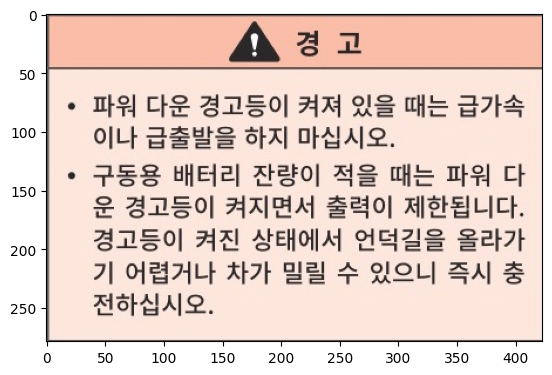

8
table: |  | 경 고 |
| --- | --- |
| y | 고전압 배터리 잔량 경고등이 켜지면 즉시 전기차 하십시오. |
| y | 충전을 고전압 배터리 잔량 경고등이 켜지면 주행 가능한 거리는 약 20km 이내이므로 즉시 충 전하십시오. 단, 주행 가능 거리는 주행 조건 에 따라 변경될 수 있습니다. |

----------------------------
summary: 이 표는 전기차의 고전압 배터리 관련 경고사항을 담고 있습니다. 주요 내용으로는:

1. 고전압 배터리 잔량 경고등이 켜지면 즉시 전기차를 충전해야 함
2. 경고등이 켜진 후 주행 가능한 거리는 약 20km 이내이므로 즉시 충전이 필요함
3. 주행 가능 거리는 주행 조건에 따라 달라질 수 있음을 안내하고 있음

이는 전기차 운전자에게 배터리 잔량이 낮을 때 취해야 할 조치에 대한 중요 안전 정보입니다.
----------------------------
----------------------------
image


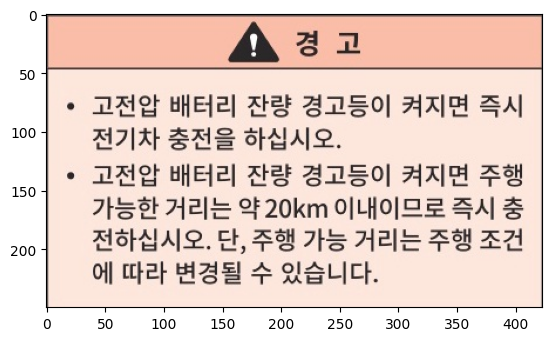

9
table: |  | 경 고 |
| --- | --- |
| y 시 당사 으십시오. | 고전압 배터리 고장 경고등이 켜지면 즉 정비사업장에서 점검 및 정비를 받 |

----------------------------
summary: 이 표는 경고 메시지를 담고 있습니다. 표의 내용에 따르면, 고전압 배터리 고장 경고등이 켜질 경우 즉시 정비사업장에서 점검 및 정비를 받으라는 안내가 제공되고 있습니다. 이는 차량 안전과 관련된 중요한 경고 사항입니다.
----------------------------
----------------------------
image


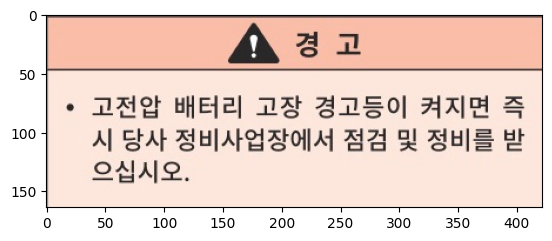

In [97]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(tables, table_summaries):

        #if table_as_image:
        #page_contents, table_as_html, img_base64 = table
        category, img_base64, table_as_html, page_contents = table["target_category"], table["target_base64"], table["target_markdown"], table["target_markdown"]
        #else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")

        print ("----------------------------")
        if img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


## 4. Index 생성
Document로 부터 추출한 text, table, 그리고 image 정보를 Amazon OpenSearch에 저장합니다. (인덱싱)  

### Index 이름 결정

In [98]:
import boto3
from src.utils.ssm import parameter_store

In [99]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [100]:
index_name = "complex-doc-index"

In [101]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [102]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [103]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [104]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [105]:
from src.utils.opensearch import opensearch_utils

In [106]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [107]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=complex-doc-index, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'complex-doc-index'}
Index is created
{'complex-doc-index': {'aliases': {},
                       'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                               'file_directory': {'type': 'text'},
                                                                               'image_base64': {'type': 'text'},
                                                                               'last_modified': {'type': 'text'},
                                                                               'origin_image': {'type': 'text'},
                                                                               'origin_table': {'type': 'text'},
                                                                               'page_nu

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [108]:
from langchain_community.vectorstores import OpenSearchVectorSearch

In [109]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [114]:
from src.utils.chunk import parant_documents

In [115]:
parent_chunk_size = 1024 # 4096 
parent_chunk_overlap = 0

child_chunk_size = 256 # 1024
child_chunk_overlap = 64 # 256 

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [116]:
texts[0].page_content

'# WINTER 표시등 스마트 하이빔(SHB) 표시등\n\n드라 이브 모 드 버튼 을 길게 터치하 여\nWINTER 모드를 선택하면 표시등이 켜집\n\n# 니다.\n\ny\n드라이브 모드 버튼을 짧게 또는 길게 터\n\n스마트 하이빔(SHB) 표시등은 시동 스위치가\nON 상태일 때 켜졌다가 약 4초 후 꺼집니다.\n라이트 스위치가 AUTO 위치일 때 스위치를\n계기판 방향으로 밀면 스마트 하이빔(SHB)\n\n치하면 다음과 같이 모드가 변경됩니다. 이 작동하고 표시등이 켜집니다. (AUTO HOLD) 표시등이 켜집니다.\n\n# ☞\n\n|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n\n\n자동 정차 유지 기능(AUTO HOLD)\n\n# 표시등/경고등\n\nAUTO HOLD 버튼을 가볍게 터치하면 자\n동 정차 브레이크 시스템이 대기 상태로 전\n환되고, 계기판에 흰색 자동 정차 유지 기능\n\nAUTO HOLD 버튼을 다시 한 번 가볍게 터\n치하면 자동 정차 유지 기능(AUTO HOLD)\n표시등이 꺼지고 자동 정차 시스템이 해제\n\n# 됩니다.\n\n4\n\n- y\n- 흰색 표시등 켜짐 : 자동 정차 유지 기능\n- 대기 상태\n- y\n- 녹색 표시등 켜짐 : 자동 정차 유지 기능\n- 작동 상태\n- y\n- 황색 경고등 켜짐 :

In [117]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 4


In [118]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='# WINTER 표시등 스마트 하이빔(SHB) 표시등\n\n드라 이브 모 드 버튼 을 길게 터치하 여\nWINTER 모드를 선택하면 표시등이 켜집\n\n# 니다.\n\ny\n드라이브 모드 버튼을 짧게 또는 길게 터\n\n스마트 하이빔(SHB) 표시등은 시동 스위치가\nON 상태일 때 켜졌다가 약 4초 후 꺼집니다.\n라이트 스위치가 AUTO 위치일 때 스위치를\n계기판 방향으로 밀면 스마트 하이빔(SHB)\n\n치하면 다음과 같이 모드가 변경됩니다. 이 작동하고 표시등이 켜집니다. (AUTO HOLD) 표시등이 켜집니다.\n\n# ☞\n\n|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n\n\n자동 정차 유지 기능(AUTO HOLD)\n\n# 표시등/경고등\n\nAUTO HOLD 버튼을 가볍게 터치하면 자\n동 정차 브레이크 시스템이 대기 상태로 전\n환되고, 계기판에 흰색 자동 정차 유지 기능\n\nAUTO HOLD 버튼을 다시 한 번 가볍게 터\n치하면 자동 정차 유지 기능(AUTO HOLD)\n표시등이 꺼지고 자동 정차 시스템이 해제\n\n# 됩니다.\n\n4\n\n- y\n- 흰색 표시등 켜짐 : 자동 

* Insert doc into OpenSearch 

In [119]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 92.3 ms, sys: 0 ns, total: 92.3 ms
Wall time: 829 ms


In [120]:
parent_chunk_docs

[Document(metadata={'family_tree': 'parent', 'parent_id': None}, page_content='# WINTER 표시등 스마트 하이빔(SHB) 표시등\n\n드라 이브 모 드 버튼 을 길게 터치하 여\nWINTER 모드를 선택하면 표시등이 켜집\n\n# 니다.\n\ny\n드라이브 모드 버튼을 짧게 또는 길게 터\n\n스마트 하이빔(SHB) 표시등은 시동 스위치가\nON 상태일 때 켜졌다가 약 4초 후 꺼집니다.\n라이트 스위치가 AUTO 위치일 때 스위치를\n계기판 방향으로 밀면 스마트 하이빔(SHB)\n\n치하면 다음과 같이 모드가 변경됩니다. 이 작동하고 표시등이 켜집니다. (AUTO HOLD) 표시등이 켜집니다.\n\n# ☞\n\n|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n\n\n자동 정차 유지 기능(AUTO HOLD)\n\n# 표시등/경고등\n\nAUTO HOLD 버튼을 가볍게 터치하면 자\n동 정차 브레이크 시스템이 대기 상태로 전\n환되고, 계기판에 흰색 자동 정차 유지 기능\n\nAUTO HOLD 버튼을 다시 한 번 가볍게 터\n치하면 자동 정차 유지 기능(AUTO HOLD)\n표시등이 꺼지고 자동 정차 시스템이 해제\n\n# 됩니다.\n\n4\n\n- y\n- 흰색 표시등 켜짐 : 자동 

In [121]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 4, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.
    - family_tree 가 parent의 경우, parent_id는 None입니다. (child가 속한 parent가 무엇인지 알려주는 용도기 때문)

In [122]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: 702d4367-a199-47fe-8ee3-3c338e029565
family_tree: parent
parent document id: None
parent document text: 
 # WINTER 표시등 스마트 하이빔(SHB) 표시등

드라 이브 모 드 버튼 을 길게 터치하 여
WINTER 모드를 선택하면 표시등이 켜집

# 니다.

y
드라이브 모드 버튼을 짧게 또는 길게 터

스마트 하이빔(SHB) 표시등은 시동 스위치가
ON 상태일 때 켜졌다가 약 4초 후 꺼집니다.
라이트 스위치가 AUTO 위치일 때 스위치를
계기판 방향으로 밀면 스마트 하이빔(SHB)

치하면 다음과 같이 모드가 변경됩니다. 이 작동하고 표시등이 켜집니다. (AUTO HOLD) 표시등이 켜집니다.

# ☞

|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |
| --- | --- |
|  | 주 의 |
| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |


자동 정차 유지 기능(AUTO HOLD)

# 표시등/경고등

AUTO HOLD 버튼을 가볍게 터치하면 자
동 정차 브레이크 시스템이 대기 상태로 전
환되고, 계기판에 흰색 자동 정차 유지 기능

AUTO HOLD 버튼을 다시 한 번 가볍게 터
치하면 자동 정차 유지 기능(AUTO HOLD)
표시등이 꺼지고 자동 정차 시스템이 해제

# 됩니다.

4

- y
- 흰색 표시등

* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [123]:
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 21


In [124]:
child_chunk_docs[0]

Document(metadata={'family_tree': 'child', 'parent_id': '702d4367-a199-47fe-8ee3-3c338e029565'}, page_content='# WINTER 표시등 스마트 하이빔(SHB) 표시등\n\n드라 이브 모 드 버튼 을 길게 터치하 여\nWINTER 모드를 선택하면 표시등이 켜집\n\n# 니다.\n\ny\n드라이브 모드 버튼을 짧게 또는 길게 터\n\n스마트 하이빔(SHB) 표시등은 시동 스위치가\nON 상태일 때 켜졌다가 약 4초 후 꺼집니다.\n라이트 스위치가 AUTO 위치일 때 스위치를\n계기판 방향으로 밀면 스마트 하이빔(SHB)')

In [125]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  702d4367-a199-47fe-8ee3-3c338e029565

###### Search parent in OpenSearch
opensearch document id: 702d4367-a199-47fe-8ee3-3c338e029565
family_tree: parent
parent document id: None
parent document text: 
 # WINTER 표시등 스마트 하이빔(SHB) 표시등

드라 이브 모 드 버튼 을 길게 터치하 여
WINTER 모드를 선택하면 표시등이 켜집

# 니다.

y
드라이브 모드 버튼을 짧게 또는 길게 터

스마트 하이빔(SHB) 표시등은 시동 스위치가
ON 상태일 때 켜졌다가 약 4초 후 꺼집니다.
라이트 스위치가 AUTO 위치일 때 스위치를
계기판 방향으로 밀면 스마트 하이빔(SHB)

치하면 다음과 같이 모드가 변경됩니다. 이 작동하고 표시등이 켜집니다. (AUTO HOLD) 표시등이 켜집니다.

# ☞

|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |
| --- | --- |
|  | 주 의 |
| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |


자동 정차 유지 기능(AUTO HOLD)

# 표시등/경고등

AUTO HOLD 버튼을 가볍게 터치하면 자
동 정차 브레이크 시스템이 대기 상태로 전
환되고, 계기판에 흰색 자동 정차 유지 기능

AUTO HOL

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searchable list (child, parent_table and parent_image) in parant document strategy.

In [126]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [127]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

In [128]:
images_preprocessed

[Document(metadata={'markdown': '|  | ☞ 스마트 하이빔(SHB)(p.160) 참조 |\n| --- | --- |\n|  | 주 의 |\n| 드라이브 모드(p.329) 참조 | 다음의 경우에는 스마트 하이빔(SHB)이 정상 적으로 작동하지 않을 수 있습니다. y 차량의 앞유리가 손상되었거나 먼지, 김 서 림, 안개, 스티커, 눈 등으로 오염된 경우 y 마주 오는 차량이나 앞서가는 차량의 램프 가 손상된 경우 y 마주 오는 차량이나 앞서가는 차량이 전방 시야에서 가려지는 경우 y 교차로 또는 굴곡이 심한 도로에서 마주 오는 차량 및 앞서가는 차량의 일부만 인 식될 경우 y 전방에 차량 램프와 유사한 광원 또는 반사 체가 있는 경우 y 공사 구간 등에 발광체나 반사체가 설치되 어 있는 경우 |\n', 'category': 'Image', 'image_base64': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIAicDeQMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+gEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoLEQACAQIEBAMEBwUEBAABAnc

### Merge text, table and image

In [129]:
from itertools import chain

In [130]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

* Insert doc into OpenSearch

In [131]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  41
CPU times: user 152 ms, sys: 6.28 ms, total: 159 ms
Wall time: 4.37 s


## 6. 검색 테스트

In [132]:
from src.utils.agentic_rag import rag_chain, OpenSearchHybridSearchRetriever
from src.utils.agentic_rag import show_context_used

In [133]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=2, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [ ]:
%%time
query = "해파리 모양 등이 떴어. 이게 뭐야?"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

CPU times: user 47.1 ms, sys: 1.89 ms, total: 48.9 ms
Wall time: 495 ms



-----------------------------------------------
1. Category: Image, Chunk: 948 Characters
-----------------------------------------------


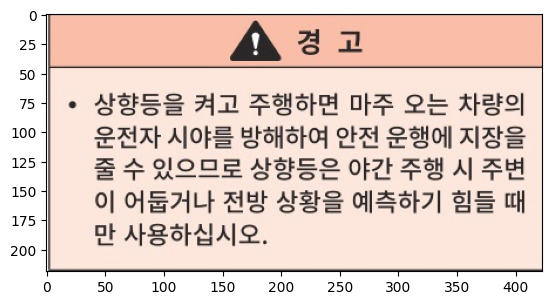

The image shows a warning notice box with a triangular exclamation mark symbol in a light
pink/salmon colored background. The text appears to be in Korean and provides a caution or warning
message about something.

Based on the context provided, I'll analyze the requested information:

## <title>
경고 (Warning/Caution)

## <summary>
이 경고문은 상향등 사용에 관한 주의사항을 담고 있습니다. 상향등을 켜고 주행할 때 마주 오는 차량의 운전자 시야를 방해하지 않도록 주의해야 함을 알리고 있으며, 마주 오는 차량이
있거나 전방 상황을 예측하기 힘들 때만 상향등을 사용할 것을 권고하고 있습니다.

## <entities>
- 상향등: 차량의 밝은 전조등으로, 어두운 곳에서 시야 확보를 위해 사용하지만 마주 오는 차량에 눈부심을 줄 수 있음
- 운전자 시야: 다른 차량 운전자의 시야 범위로, 상향등에 의해 방해받을 수 있음
- 차선유지보조(LKA): 문서 컨텍스트에 언급된 기능으로, 차량이 차선을 유지하도록 돕는 시스템
- 차선이탈경고(LDW): 문서 컨텍스트에 언급된 기능으로, 차량이 차선을 이탈할 때 경고하는 시스템
- 중앙차선유지보조(CLKA): 문서 컨텍스트에 언급된 기능으로, 차량이 차선 중앙을 유지하도록 돕는 시스템

## <hypothetical_questions>
- 상향등은 언제 사용해야 하나요?
- 상향등 사용 시 주의해야 할 점은 무엇인가요?
- 마주 오는 차량이 있을 때 상향등을 사용해도 될까요?
- 차선유지보조 기능과 상향등 사용은 어떤 관련이 있나요?
- 상향등 표시등은 어떤 색상으로 표시되나요?
metadata:
 {'markdown': '| 경 | 고 |\n| --- | --- |\n

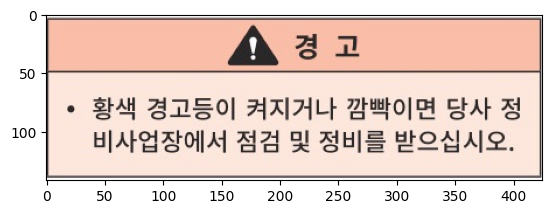

이 표는 경고에 관한 정보를 제공하고 있습니다. 황색 비사업장에서 경고등이 켜지거나 깜빡이면 당사 정비점에서 점검 및 정비를 받아야 한다는 내용을 안내하고 있습니다.


metadata:
 {'origin_table': '|  | 경 고 |\n| --- | --- |\n| y 황색 비사업장에서 | 경고등이 켜지거나 깜빡이면 당사 정 점검 및 정비를 받으십시오.
|\n', 'text_as_html': '|  | 경 고 |\n| --- | --- |\n| y 황색 비사업장에서 | 경고등이 켜지거나 깜빡이면 당사 정 점검 및 정비를
받으십시오. |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table', 'parent_id':
'NA', 'id': '465d5534-564e-42be-bb33-351747ef0bfe', 'origin_image': '', 'orig_elements': ''}


In [135]:
show_context_used(search_hybrid_result)

### RAG

In [136]:
from textwrap import dedent

In [137]:
system_prompt = dedent(
    """
    You are a master answer bot designed to answer user's questions.
    I'm going to give you contexts which consist of texts, tables and images.
    Read the contexts carefully, because I'm going to ask you a question about it.
    """
)

human_prompt = dedent(
    """
    Here is the contexts as texts: <contexts>{contexts}</contexts>

    First, find a few paragraphs or sentences from the contexts that are most relevant to answering the question.
    Then, answer the question as much as you can.

    Skip the preamble and go straight into the answer.
    Don't insert any XML tag such as <contexts> and </contexts> when answering.
    Answer in Korean.

    Here is the question: <question>{question}</question>

    If the question cannot be answered by the contexts, say "No relevant contexts".
    """
)

In [138]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    human_prompt=human_prompt,
    return_context=True,
    verbose=False,
)

In [139]:
query = "해파리 모양 등이 떴어. 이게 뭐야?"

response, contexts = qa.invoke(
    query = query
)

verbose False
제공된 맥락에서는 해파리 모양의 경고등에 대한 구체적인 정보를 찾을 수 없습니다. 다만, 이미지에 보이는 경고문은 경고등이 켜지거나 깜빡이면 당사 정비사업장에서 점검 및 정비를 받으라는 일반적인 안내를 하고 있습니다. 해파리 모양의 특정 경고등에 대한 설명은 제공된 자료에 포함되어 있지 않습니다.

자동차에 해파리 모양과 유사한 경고등이 켜졌다면, 차량 매뉴얼을 확인하거나 정비사업장에 방문하여 정확한 의미와 필요한 조치에 대해 문의하시는 것이 좋겠습니다.


-----------------------------------------------
1. Category: Table, Chunk: 291 Characters
-----------------------------------------------


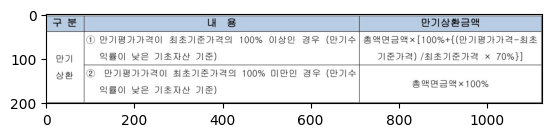

이 표는 만기 상환에 관한 내용을 설명하고 있습니다. 두 가지 경우로 나누어져 있습니다:

1. 만기평가가격이 최초기준가격의 100% 이상인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×[100%+{(만기평가가격-최초기준가격)/최초기준가격 × 70%}]의
금액을 상환받습니다.

2. 만기평가가격이 최초기준가격의 100% 미만인 경우: 만기수익률이 낮은 기초자산을 기준으로 총액면금액×100%의 금액을 상환받습니다.

즉, 만기평가가격이 기준가격 이상이면 추가 수익이 발생하고, 미만이더라도 원금은 보장됩니다.


metadata:
 {'origin_table': '| 구 분 | 내 용 | 만기상환금액 |\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인
경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이
최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은 기초자산 기준) | 총액면금액×100% |\n', 'text_as_html': '| 구 분 | 내 용 | 만기상환금액
|\n| --- | --- | --- |\n| 만기 상환 | ① 만기평가가격이 최초기준가격의 100% 이상인 경우 (만기수 익률이 낮은 기초자산 기준) |
총액면금액×[100%+{(만기평가가격-최초 기준가격) /최초기준가격 × 70%}] |\n| 만기 상환 | ② 만기평가가격이 최초기준가격의 100% 미만인 경우 (만기수 익률이 낮은
기초자산 기준) | 총액면금액×100% |\n', 'category': 'Table', 'image_base64': '', 'family_tree': 'parent_table',
'parent_id': 'NA', 'id': '854da525-94fc-4d55-9da7-29c6da433979', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Chunk: 981 Characters
-----------------------------------------------
핵 심 설 명 서

이 설명서는 금융소비자의 권익 보호 및 금융상품에 대한 이해 증진을 위하여
금융상품의 핵심내용을 쉽게 이해하실 수 있도록 작성한 것입니다. 상품내용을
충분히 이해하신 다음에 청약여부를 결정하시기 바랍니다.

# 핵심설명서

# [미래에셋증권 제 253 회 파생결합증권(DLS)(원금보장형)]

# 1



In [88]:
show_context_used(contexts)

# SageMaker Processing Job 이용하기

## 1. scripy 만들기

In [ ]:
%%writefile ./src/preprocessing.py

import os
import json
import copy
import boto3
import shutil
import argparse
from pprint import pprint
from utils import bedrock
from itertools import chain
from utils.bedrock import bedrock_info

from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

import math
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from langchain.schema import Document
from pdf2image import convert_from_path
from requests_toolbelt import MultipartEncoder

import botocore
from utils.common_utils import retry
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

from utils.chunk import parant_documents
from utils.opensearch import opensearch_utils
from langchain_community.vectorstores import OpenSearchVectorSearch

class preprocess():
    
    def __init__(self, args):
        
        self.args = args
        self.proc_prefix = self.args.proc_prefix #'/opt/ml/processing'
        
        self.input_dir = os.path.join(self.proc_prefix, "input")
        self.output_dir = os.path.join(self.proc_prefix, "output")
        os.makedirs(self.input_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)
        
        print (os.listdir(self.input_dir))
        
        ############# 수정
        #self.file_path = os.path.join(self.input_dir, "sample-2.pdf")
        self.file_path = os.path.join(self.input_dir, self.args.file_name)
        #"./data/complex_pdf/sample-2.pdf"
        ###############
        
    def _initialization(self, ):
        
        self.boto3_bedrock = bedrock.get_bedrock_client(
            assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
            endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
            region=os.environ.get("AWS_DEFAULT_REGION", None),
        )
        
        self.llm_text = ChatBedrock(
            model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
            client=self.boto3_bedrock,
            streaming=True,
            callbacks=[StreamingStdOutCallbackHandler()],
            model_kwargs={
                "max_tokens": 2048,
                "stop_sequences": ["\n\nHuman"],
            }
        )
        
        self.llm_emb = BedrockEmbeddings(
            client=self.boto3_bedrock,
            model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
        )
        self.dimension = 1024
        
    def _document_parsing(self, ):
        
        runtime_sm_client = boto3.client('runtime.sagemaker')

        # Prepare multipart form data
        encoder = MultipartEncoder(
            fields={
                'document': (os.path.basename(self.file_path), open(self.file_path, 'rb'), 'application/pdf'),
                'model': 'document-parse',
                'ocr': 'auto',
                'coordinates': 'true',
                'output_formats': '["markdown"]', #'["text", "html", "markdown"]',
                'base64_encoding': '["table", "figure"]'
            }
        )

        # Get the raw bytes of the multipart form data
        body = encoder.to_string()

        response = runtime_sm_client.invoke_endpoint(
            EndpointName=self.args.endpoint_document_parser,
            ContentType=encoder.content_type,  # This will be 'multipart/form-data; boundary=...'
            Body=body
        )

        result = response["Body"].read()
        parse_output = json.loads(result)
        
        return parse_output
    
    def _extract_image_table(self, parse_output):
        
        def processing(**kwargs):
    
            category = kwargs["category"]
            markdown = kwargs["markdown"]
            base64_encoding = kwargs["base64_encoding"]
            coordinates = kwargs["coordinates"]
            page = kwargs["page"]
            docs = kwargs["docs"]

            if page in docs: 
                docs[page].append(
                    {
                        "category": category,
                         "markdown": markdown,
                         "base64_encoding": base64_encoding,
                         "coordinates": coordinates
                    }
                )
            else:
                docs[page] = [
                    {
                        "category": category,
                        "markdown": markdown,
                        "base64_encoding": base64_encoding,
                        "coordinates": coordinates
                    }
                ]

            return docs

        def image_conversion(**kwargs):

            image_path = kwargs["image_path"]
            file_path = kwargs["file_path"]

            image_tmp_path = os.path.join(image_path, "tmp")
            if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
            os.mkdir(image_tmp_path)

            # from pdf to image
            pages = convert_from_path(file_path)
            for i, page in enumerate(pages):
                print (f'pdf page {i}, size: {page.size}')    
                page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

            return image_tmp_path
        
        image_path = os.path.join(self.input_dir, "fig")
        if os.path.isdir(image_path): shutil.rmtree(image_path)
        os.mkdir(image_path)
        
        docs = {}
        texts = [
            Document(
                page_content=parse_output["content"]["markdown"]
            )
        ]

        ## extract_image_table
        image_tmp_path = image_conversion(
            image_path=image_path,
            file_path=self.file_path
        )

        for idx, value in enumerate(parse_output["elements"]):

            category = value["category"]
            markdown = value["content"]["markdown"]
            page = value["page"]

            if category in ["figure", "table"]:

                base64_encoding = value["base64_encoding"]    
                coordinates = value["coordinates"]    
                img = Image.open(BytesIO(base64.b64decode(base64_encoding)))
                plt.imshow(img)
                plt.show()

                page_img = Image.open(f'{image_tmp_path}/{page}.jpg')
                w, h = page_img.size  # PIL은 (width, height) 순서

                # 좌표 계산
                left = math.ceil(coordinates[0]["x"] * w)
                top = math.ceil(coordinates[0]["y"] * h)
                right = math.ceil(coordinates[1]["x"] * w)
                bottom = math.ceil(coordinates[3]["y"] * h)

                # PIL로 이미지 크롭
                crop_img = page_img.crop((left, top, right, bottom))
                        
                crob_image_path = f'{image_path}/element-{idx}.jpg'
                crop_img.save(crob_image_path)

                w_crop, h_crop = crop_img.size
                image_token = w_crop*h_crop/750
                print (f'image: {crob_image_path}, shape: ({w_crop}, {h_crop}), image_token_for_claude3: {image_token}' )
                
            else:
                base64_encoding= ""
                coordinates=""

            docs = processing(
                docs=docs,
                page=page,
                category=category,
                markdown=markdown,
                base64_encoding=base64_encoding,
                coordinates=coordinates
            )
            
        return docs, texts
    
    def _context_generation_for_image(self, docs):
        
        def manipulate_docs_for_summary(docs):
            
            docs_for_summary = []
            for page, elements in docs.items():

                elements = [element for element in elements if element["category"] != "footer"]
                print (f'page: {page}, # elements: {len(elements)}')

                for idx, element in enumerate(elements):

                    category, markdown = element["category"], element["markdown"]
                    print (f'element idx: {idx}, category: {element["category"]}')

                    elements_copy = copy.deepcopy(elements)
                    if category in ("figure", "table"):  
                        
                        summary_target = elements_copy.pop(idx)
                        contexts_markdown = '\n'.join([context["markdown"] for context in elements_copy])
                        docs_for_summary.append(
                            {
                                "target_category": summary_target["category"],
                                "target_base64": summary_target["base64_encoding"],
                                "target_markdown": summary_target["markdown"],
                                "contexts_markdown": contexts_markdown
                            }
                        )
                
            return docs_for_summary
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

            human_prompt = [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/png;base64," + "{image_base64}",
                    },
                },
                {
                    "type": "text",
                    "text": '''
                             <contexts>
                             {contexts}
                             </contexts>

                             주어진 이미지 또는 테이블을 자세히 분석하고 주어진 contexts를 참고하여 다음 정보를 추출해주세요:

                             1. <title> 태그 안의 제목을 정확히 제시해주세요.
                             2. <summary> 태그 안의 내용을 요약해주세요.
                             3. <entities> 태그 안의 모든 항목을 나열하고, 각 항목에 대한 간단한 설명을 제공해주세요.
                             4. <hypothetical_questions> 태그 안의 질문들을 모두 나열해주세요.
                            모든 정보는 원본 내용을 정확히 반영하되, 필요한 경우 약간의 추가 설명을 덧붙여 이해를 돕도록 해주세요.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)
            
            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
        def summary_img(summarize_chain, image_base64, contexts):

            img = Image.open(BytesIO(base64.b64decode(image_base64)))
            plt.imshow(img)
            plt.show()

            stream = summarize_chain.stream(
                {
                    "image_base64": image_base64,
                    "contexts": contexts
                }
            )
            response = ""
            for chunk in stream: response += chunk

            return response
            
        docs_for_summary = manipulate_docs_for_summary(docs)
        
        print ("docs_for_summary", len(docs_for_summary))
        
        
        summarize_chain = get_summary_chain()
        
        summaries = []
        for idx, doc in enumerate(docs_for_summary):
            summary = summary_img(summarize_chain, doc["target_base64"], doc["contexts_markdown"])
            summaries.append(summary)
            print ("\n==")
            print (idx)
            
        images_preprocessed = []
        for doc, summary in zip(docs_for_summary, summaries):

            metadata = {}
            metadata["markdown"] = doc["target_markdown"]
            metadata["category"] = "Image"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            images_preprocessed.append(doc)
            
        for image in images_preprocessed:
            image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"
        
        return images_preprocessed, docs_for_summary

    def _context_generation_for_table(self, docs_for_summary):
        
        def get_summary_chain():
            
            system_prompt = "You are an assistant tasked with describing table and image."
            system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
            
            human_prompt = [
                {
                    "type": "text",
                    "text": '''
                             Here is the table: <table>{table}</table>
                             Given table, give a concise summary.
                             Don't insert any XML tag such as <table> and </table> when answering.
                             Write in Korean.
                    '''
                },
            ]
            human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

            prompt = ChatPromptTemplate.from_messages(
                [
                    system_message_template,
                    human_message_template
                ]
            )

            summarize_chain = {"table": lambda x:x} | prompt | self.llm_text | StrOutputParser()
            
            return summarize_chain
        
        tables = [doc for doc in docs_for_summary if doc["target_category"] == "table"]
        summarize_chain = get_summary_chain()
        table_info = [t["target_markdown"] for t in tables]
        table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
        
        tables_preprocessed = []
        for doc, summary in zip(tables, table_summaries):

            metadata = {}
            metadata["origin_table"] = doc["target_markdown"]
            metadata["text_as_html"] = doc["target_markdown"]
            metadata["category"] = "Table"
            metadata["image_base64"] = doc["target_base64"]

            doc = Document(
                page_content=summary,
                metadata=metadata
            )
            tables_preprocessed.append(doc)
        
        for table in tables_preprocessed:
            table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"
            
        return tables_preprocessed
    
    def _opensearch(self, ):
        
        index_body = {
            'settings': {
                'analysis': {
                    'analyzer': {
                        'my_analyzer': {
                                 'char_filter':['html_strip'],
                            'tokenizer': 'nori',
                            'filter': [
                                #'nori_number',
                                #'lowercase',
                                #'trim',
                                'my_nori_part_of_speech'
                            ],
                            'type': 'custom'
                        }
                    },
                    'tokenizer': {
                        'nori': {
                            'decompound_mode': 'mixed',
                            'discard_punctuation': 'true',
                            'type': 'nori_tokenizer'
                        }
                    },
                    "filter": {
                        "my_nori_part_of_speech": {
                            "type": "nori_part_of_speech",
                            "stoptags": [
                                "J", "XSV", "E", "IC","MAJ","NNB",
                                "SP", "SSC", "SSO",
                                "SC","SE","XSN","XSV",
                                "UNA","NA","VCP","VSV",
                                "VX"
                            ]
                        }
                    }
                },
                'index': {
                    'knn': True,
                    'knn.space_type': 'cosinesimil'  # Example space type
                }
            },
            'mappings': {
                'properties': {
                    'metadata': {
                        'properties': {
                            'source': {'type': 'keyword'},
                            'page_number': {'type':'long'},
                            'category': {'type':'text'},
                            'file_directory': {'type':'text'},
                            'last_modified': {'type': 'text'},
                            'type': {'type': 'keyword'},
                            'image_base64': {'type':'text'},
                            'origin_image': {'type':'text'},
                            'origin_table': {'type':'text'},
                        }
                    },
                    'text': {
                        'analyzer': 'my_analyzer',
                        'search_analyzer': 'my_analyzer',
                        'type': 'text'
                    },
                    'vector_field': {
                        'type': 'knn_vector',
                        'dimension': f"{self.dimension}" # Replace with your vector dimension
                    }
                }
            }
        }

        opensearch_domain_endpoint = self.args.opensearch_domain_endpoint
        opensearch_user_id = self.args.opensearch_user_id
        opensearch_user_password = self.args.opensearch_user_password
        index_name = self.args.index_name
        
        http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password
        
        ## opensearch clinet 생성
        aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
        os_client = opensearch_utils.create_aws_opensearch_client(
            aws_region,
            opensearch_domain_endpoint,
            http_auth
        )
        
        ## opensearch index 생성
        index_exists = opensearch_utils.check_if_index_exists(
            os_client,
            index_name
        )

        if index_exists:
            opensearch_utils.delete_index(
                os_client,
                index_name
            )

        opensearch_utils.create_index(os_client, index_name, index_body)
        index_info = os_client.indices.get(index=index_name)
        print("Index is created")
        pprint(index_info)
        
        vector_db = OpenSearchVectorSearch(
            index_name=index_name,
            opensearch_url=opensearch_domain_endpoint,
            embedding_function=self.llm_emb,
            http_auth=http_auth, # http_auth
            is_aoss=False,
            engine="faiss",
            space_type="l2",
            bulk_size=100000,
            timeout=60
        )
        
        return os_client, vector_db, index_name
        
    def _chunking_and_indexing(self, os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed):
        
        parent_chunk_size = 4096
        parent_chunk_overlap = 0

        child_chunk_size = 1024
        child_chunk_overlap = 256

        opensearch_parent_key_name = "parent_id"
        opensearch_family_tree_key_name = "family_tree"
        
        parent_chunk_docs = parant_documents.create_parent_chunk(
            docs=texts,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name,
            parent_chunk_size=parent_chunk_size,
            parent_chunk_overlap=parent_chunk_overlap
        )
        print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')
        parent_ids = vector_db.add_documents(
            documents = parent_chunk_docs, 
            vector_field = "vector_field",
            bulk_size = 1000000
        )
        
        total_count_docs = opensearch_utils.get_count(os_client, index_name)
        print("total count docs: ", total_count_docs)
                
        # child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
        child_chunk_docs = parant_documents.create_child_chunk(
            child_chunk_size=child_chunk_size,
            child_chunk_overlap=child_chunk_overlap,
            docs=parent_chunk_docs,
            parent_ids_value=parent_ids,
            parent_id_key=opensearch_parent_key_name,
            family_tree_id_key=opensearch_family_tree_key_name
        )

        print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")
        parent_id = child_chunk_docs[0].metadata["parent_id"]
        print("child's parent_id: ", parent_id)
        print("\n###### Search parent in OpenSearch")
        
        
        ## Merge
        docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))
        
        child_ids = vector_db.add_documents(
            documents=docs_preprocessed, 
            vector_field = "vector_field",
            bulk_size=1000000
        )
        print("length of child_ids: ", len(child_ids))
        
        return child_chunk_docs
        
    def execution(self, ):
        
        ## Initialization for Bedrock
        self._initialization()
        
        ## Document parsing
        parse_output = self._document_parsing()
        
        ## Context generation for images and tables
        docs, texts = self._extract_image_table(parse_output)
        images_preprocessed, docs_for_summary = self._context_generation_for_image(docs)
        tables_preprocessed = self._context_generation_for_table(docs_for_summary)
        
        ## Opensearch setting
        os_client, vector_db, index_name = self._opensearch()
        
        ## Chunking(Parent document) and indexing
        child_chunk_docs = self._chunking_and_indexing(os_client, vector_db, index_name, texts, images_preprocessed, tables_preprocessed)
        
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--region", type=str, default="us-west-2")
    parser.add_argument("--proc_prefix", type=str, default="./src")
    parser.add_argument("--endpoint_document_parser", type=str, default="")
    parser.add_argument("--opensearch_domain_endpoint", type=str, default="")
    parser.add_argument("--opensearch_user_id", type=str, default="")
    parser.add_argument("--opensearch_user_password", type=str, default="")
    parser.add_argument("--index_name", type=str, default="")
    parser.add_argument("--file_name", type=str, default="")
    
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))
    
    os.environ['AWS_DEFAULT_REGION'] = args.region
        
    prep = preprocess(args)
    prep.execution()
    

In [ ]:
#!python ./src/preprocessing.py

## 2. parser용 이미지 생성하기
 **[중요] ECR 사용을 위해 "AmazonEC2ContainerRegistryFullAccess" policy를 role에 추가해야 합니다**

In [ ]:
import sagemaker
from utils.ecr import ecr_handler

In [ ]:
ecr = ecr_handler()
region=boto3.Session().region_name
strAccountID = boto3.client("sts").get_caller_identity().get("Account")

In [ ]:
container_uri = sagemaker.image_uris.retrieve(
    framework="sklearn", version="1.2-1", region=region
)
container_uri

In [ ]:
%%writefile ./custom-docker/Dockerfile-docparse

FROM 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3

RUN wget -O - https://apt.kitware.com/keys/kitware-archive-latest.asc 2>/dev/null | gpg --dearmor - | tee /usr/share/keyrings/kitware-archive-keyring.gpg >/dev/null
RUN apt-get update
RUN apt-get install -y libgl1-mesa-glx
RUN apt-get install -y libglib2.0-0
RUN apt-get install -y poppler-utils

RUN pip install -U pip
RUN pip install botocore==1.39.10
RUN pip install boto3==1.39.9
RUN pip install sagemaker==2.248.1
RUN pip install langchain==0.3.26
RUN pip install langchain_aws==0.2.29
RUN pip install langchain_community==0.3.20
RUN pip install requests_toolbelt==1.0.0
RUN pip install pdf2image==1.17.0
RUN pip install numpy==1.26.4
RUN pip install ipython==8.18.1
RUN pip install opensearch-py==3.0.0
RUN pip install matplotlib==3.9.4
RUN pip install pillow>=10.0.0

ENV PYTHONUNBUFFERED=TRUE

In [ ]:
import botocore
botocore.__version__

In [ ]:
strRepositoryName="docparse-image"  ## <-- 원하는 docker repostory 이름을 추가
strRepositoryName = strRepositoryName.lower()
strDockerFile = "Dockerfile-docparse"
strDockerDir = "./custom-docker/"
strTag = "latest"

In [ ]:
## Build
#ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="ap-northeast-2", strAccountId="246618743249")
ecr.build_docker(strDockerDir, strDockerFile, strRepositoryName, strRegionName="us-west-2", strAccountId="246618743249")

In [ ]:
## Upload to ECR
strEcrRepositoryUri = ecr.register_image_to_ecr(region, strAccountID, strRepositoryName, strTag)

In [ ]:
strEcrRepositoryUri = "615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image"

## 3. 파일 업로드 to S3

In [ ]:
import sagemaker
from utils.s3 import s3_handler

In [ ]:
sagemaker_session = sagemaker.Session()
strBucketName = sagemaker_session.default_bucket() # 기본 버킷 이름 가져오기
strLocalDataPath = "./data/complex_pdf/"

In [ ]:
s3 = s3_handler()
source_dir, target_bucket, target_dir = strLocalDataPath, strBucketName, "doc_parse_data"
s3.upload_dir(source_dir, target_bucket, target_dir)

strS3DataPath = f's3://{strBucketName}/doc_parse_data'

## 3. Processing Job 실행

In [ ]:
import os
from utils.ssm import parameter_store
from sagemaker import get_execution_role
#from sagemaker.pytorch.estimator import PyTorch
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

In [ ]:
strRegionName = boto3.Session().region_name
strAccountId = boto3.client("sts").get_caller_identity().get("Account")
strPrefix = "doc-parse"

In [ ]:
local_mode = False

#strExecutionRole = get_execution_role()
strExecutionRole = "<your sagemaker role>"
strExecutionRole = "arn:aws:iam::615299776985:role/service-role/AmazonSageMaker-ExecutionRole-20241014T132050"

if local_mode: 
    strInstanceType = 'local'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data", "complex_pdf"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

In [ ]:
dataset_processor = FrameworkProcessor(
    estimator_cls=SKLearn,
    framework_version="1.2-1",
    py_version="py3",
    image_uri="615299776985.dkr.ecr.us-west-2.amazonaws.com/docparse-image",#"<your image uri>"
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"
strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

pm = parameter_store(strRegionName)
endpoint_document_parser = "<endpoint-name>"
endpoint_document_parser = "Upstage-Document-Parse-2025-07-22-06-56-52-438"

opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)
opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)
opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)
index_name = "sm_prep_job"
file_name = "sample-2.pdf"

In [ ]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--region", region, \
        "--endpoint_document_parser", endpoint_document_parser, \
        "--opensearch_domain_endpoint", opensearch_domain_endpoint, \
        "--opensearch_user_id", opensearch_user_id, \
        "--opensearch_user_password", opensearch_user_password, \
        "--index_name", index_name, \
        "--file_name", file_name
    ]
)


## 확인하기

In [ ]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name="sm_prep_job",
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name = "cohere-reranker-3-5", # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=True,

)

In [ ]:
%%time
query = "조기상환 여부에 따른 투자 수익률"
search_hybrid_result, tables, images = opensearch_hybrid_retriever.invoke(query)

In [ ]:
show_context_used(search_hybrid_result)